## Using Q-Learning: Off-Policy Learning

### Part 1: Implementation of Easy21

Same 2 same

In [25]:
import random, numpy as np

In [26]:
def draw_card():
    value = random.randint(1, 10)
    colour_value = random.random()
    if colour_value < 0.33:
        return -value
    else:
        return value

In [27]:
def step(s, a): # s is the state (top card of dealer, total sum of cards of player) of the game, a is the action (hit or stick), shoud sample a next state s' and reward r.
    if a == 0: # hit
        if s[1] < 21:
            card_value = draw_card() # should return appropriate value of card with correct sign (black -> add, red -> subtract)
            s_new = (s[0], s[1] + card_value)
            if s_new[1] > 21 or s_new[1]< 1 : # player busts
                return s_new, -1
            else:
                return s_new, 0
        else:
            return s, 0
    else: # stick
        dealer_card = draw_card()
        while dealer_card < 17: # dealer hits until the sum is at least 17
            dealer_card += draw_card()
        if dealer_card > 21: # dealer busts
            return s, 1
        elif dealer_card < s[1]: # player wins
            return s, 1
        elif dealer_card == s[1]: # draw
            return s, 0
        else: # dealer wins
            return s, -1

# What is the exact meaning of the "top card of the dealer"?, we are not updating that anywhere in the game, so not sure why it is needed.

### Part 2: Q-Learning implementation

In [28]:
# N = np.zeros((11, 22, 2, 11))
# V = np.zeros((11, 22, 2, 11))
# N0 = 100
# gamma = 1.0

# number_of_episodes = 100000
# lambda_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# for lambda_idx, lambda_val in enumerate(lambda_values):
#     for episode in range(number_of_episodes):
#         top_card = random.randint(1, 10)
#         player_sum = random.randint(1, 10)
#         s = (top_card, player_sum)
#         a = 0 if random.random() < 0.5 else 1
#         N[top_card, player_sum, a, lambda_idx] += 1

#         while True:
#             s_new, r = step(s, a)

#             if s_new[1] >= 1 and s_new[1] <= 21:
#                 N[s_new[0], s_new[1], a, lambda_idx] += 1
#                 epsilon_t = N0 / (N0 + N[s_new[0], s_new[1], a, lambda_idx])
#                 a_new = np.argmax(V[s[0], s[1], :, lambda_idx]) if random.random() > epsilon_t else random.randint(0, 1)
#                 alpha_t = 1 / N[s_new[0], s_new[1], a, lambda_idx]

#                 V[s[0], s[1], a, lambda_idx] += alpha_t * (r + gamma * max(V[s_new[0], s_new[1], :, lambda_idx]) - V[s[0], s[1], a, lambda_idx])

#                 s = s_new
#                 a = a_new

#             if r != 0:
#                 break

In [29]:
def get_optimal_value():
    N = np.zeros((11, 22, 2)) # x -> top card, y -> sum of player, z -> action
    number_of_episodes = 100000

    V = np.zeros((11, 22, 2, number_of_episodes + 1))
    N0 = 100

    for episode in range(number_of_episodes):
        player_value = random.randint(1, 10)
        dealer_value = random.randint(1, 10)
        s = (dealer_value, player_value)
        a = 0 if random.random() < 0.5 else 1 # choose first action randomly

        episode_trajectory = []

        while True:
            s_new, r = step(s, a)
            episode_trajectory.append((s, a, r))

            if r != 0:
                break

            s = s_new
            epsilon_t = N0 / (N0 + N[s[0], s[1], a])
            a = np.argmax(V[s[0], s[1], :, episode]) if random.random() > epsilon_t else random.randint(0, 1)

        G = 0

        for t in reversed(range(len(episode_trajectory))):
            s_t, a_t, r_t = episode_trajectory[t]
            G += r_t

            first_visit = True
            for j in range(t):
                prev_state, prev_action, _ = episode_trajectory[j]
                if prev_state == s_t and prev_action == a_t:
                    first_visit = False
                    break

            if first_visit and s_t[1] >= 1 and s_t[1] <= 21:
                N[s_t[0], s_t[1], a_t] += 1
                alpha = 1 / N[s_t[0], s_t[1], a_t]
                V[s_t[0], s_t[1], a_t, episode + 1] = V[s_t[0], s_t[1], a_t, episode] + alpha * (G - V[s_t[0], s_t[1], a_t, episode])

        V[:, :, :, episode + 1] = np.where(V[:, :, :, episode + 1] == 0, V[:, :, :, episode], V[:, :, :, episode + 1])

    Z_0 = np.transpose(V[:, :, 0, number_of_episodes - 1])
    Z_1 = np.transpose(V[:, :, 1, number_of_episodes - 1])
    Z = np.maximum(Z_0, Z_1)
    return Z.transpose()

In [30]:
N = np.zeros((11, 22, 2, 11))
number_of_episodes = 100000
V = np.zeros((11, 22, 2, 11, number_of_episodes))
N0 = 100
gamma = 1.0

lambda_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

track_every = 100
tracked_episodes = []

instantaneous_regret = np.zeros((len(lambda_values), number_of_episodes))
cumulative_regret = np.zeros((len(lambda_values), number_of_episodes))

V_optimal = get_optimal_value()

for lambda_idx, lambda_val in enumerate(lambda_values):

    for episode in range(number_of_episodes):
        top_card = random.randint(1, 10)
        player_sum = random.randint(1, 10)
        s = (top_card, player_sum)
        a = 0 if random.random() < 0.5 else 1
        N[top_card, player_sum, a, lambda_idx] += 1

        while True:
            s_new, r = step(s, a)

            if s_new[1] >= 1 and s_new[1] <= 21:
                N[s_new[0], s_new[1], a, lambda_idx] += 1
                epsilon_t = N0 / (N0 + N[s_new[0], s_new[1], a, lambda_idx])
                a_new = np.argmax(V[s[0], s[1], :, lambda_idx, episode]) if random.random() > epsilon_t else random.randint(0, 1)
                alpha_t = 1 / N[s_new[0], s_new[1], a, lambda_idx]

                if episode == 0:
                    V[s[0], s[1], a, lambda_idx, episode] = alpha_t * (r + gamma * max(V[s_new[0], s_new[1], :, lambda_idx, episode]) - 0)
                else:
                    V[s[0], s[1], a, lambda_idx, episode] = V[s[0], s[1], a, lambda_idx, episode-1] + alpha_t * (r + gamma * max(V[s_new[0], s_new[1], :, lambda_idx, episode]) - V[s[0], s[1], a, lambda_idx, episode-1])

                optimal_value = V_optimal[s_new[0], s_new[1]]
                actual_value = max(V[s_new[0], s_new[1], :, lambda_idx, episode])
                inst_regret = optimal_value - actual_value
                instantaneous_regret[lambda_idx, episode] = inst_regret
                if episode == 0:
                    cumulative_regret[lambda_idx, episode] = inst_regret
                else:
                    cumulative_regret[lambda_idx, episode] = cumulative_regret[lambda_idx, episode-1] + inst_regret

                s = s_new
                a = a_new

            if r != 0:
                break

        if episode < number_of_episodes - 1:
            V[:, :, :, lambda_idx, episode + 1] = V[:, :, :, lambda_idx, episode]


### Part 3: Plotting the value function and optimal policy

In [31]:
import matplotlib.pyplot as plt

In [32]:
def plot_for_lambda(l):
    l = int(l * 10)
    Z_0 = np.transpose(V[:, :, 0, l, number_of_episodes - 1])
    Z_1 = np.transpose(V[:, :, 1, l, number_of_episodes - 1])
    Z = np.maximum(Z_0, Z_1)
    Z_diff = Z_1 - Z_0
    optimal_policy = np.argmax(V[:, :, :, l, number_of_episodes - 1], axis=2)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(np.arange(0, 11), np.arange(0, 22))
    ax.plot_surface(X, Y, Z_0, cmap='viridis')
    ax.set_xlabel('Dealer Top Card')
    ax.set_ylabel('Player Total Value')
    ax.set_zlabel('Value of Hit Action')
    ax.set_title('Value Function for Easy21 - Hit Action')
    plt.show()

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z_1, cmap='viridis')
    ax.set_xlabel('Dealer Top Card')
    ax.set_ylabel('Player Total Value')
    ax.set_zlabel('Value of Stick Action')
    ax.set_title('Value Function for Easy21 - Stick Action')
    plt.show()

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('Dealer Top Card')
    ax.set_ylabel('Player Total Value')
    ax.set_zlabel('Value of Optimal Action')
    ax.set_title('Optimal Value Function for Easy21')
    plt.show()

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z_diff, cmap='viridis')
    ax.set_xlabel('Dealer Top Card')
    ax.set_ylabel('Player Total Value')
    ax.set_zlabel('Difference in Action Values')
    ax.set_title('Difference in Value Function for Easy21')
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.imshow(optimal_policy.T, origin='lower', aspect='auto', cmap='coolwarm')
    plt.colorbar(label='Action (0: Hit, 1: Stick)')
    plt.xlabel('Dealer Top Card')
    plt.ylabel('Player Total Value')
    plt.title('Optimal Policy for Easy21 (0: Hit, 1: Stick)')
    plt.xticks(ticks=np.arange(optimal_policy.shape[0]), labels=np.arange(optimal_policy.shape[0]))
    plt.yticks(ticks=np.arange(optimal_policy.shape[1]), labels=np.arange(optimal_policy.shape[1]))
    plt.show()

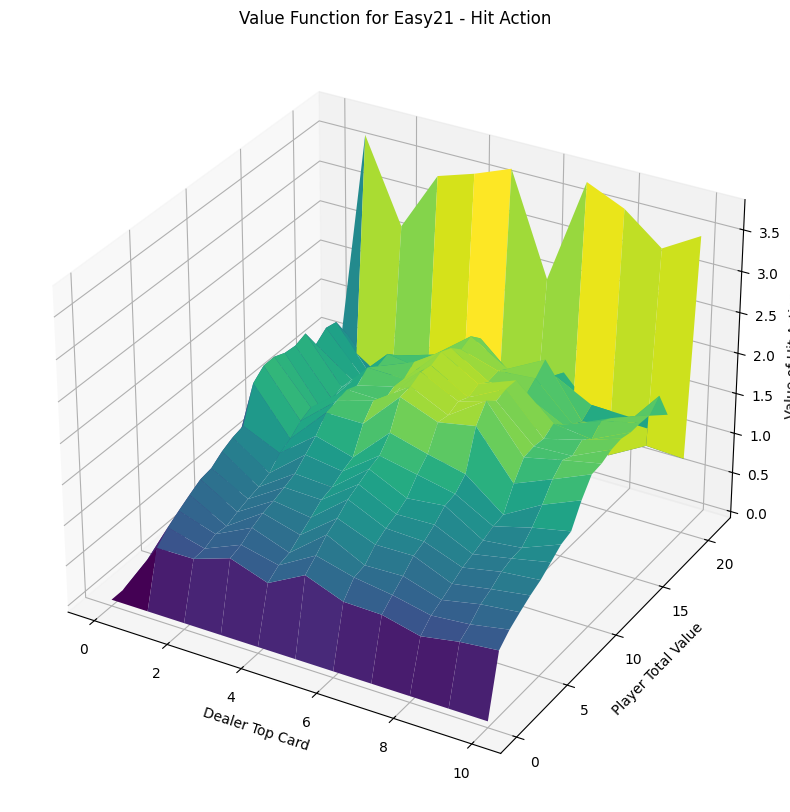

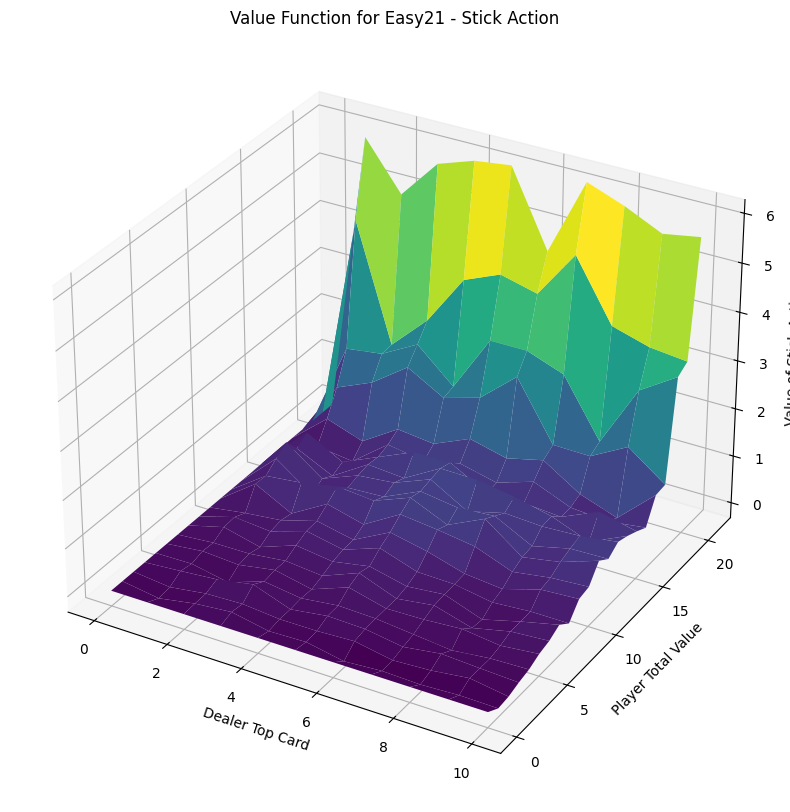

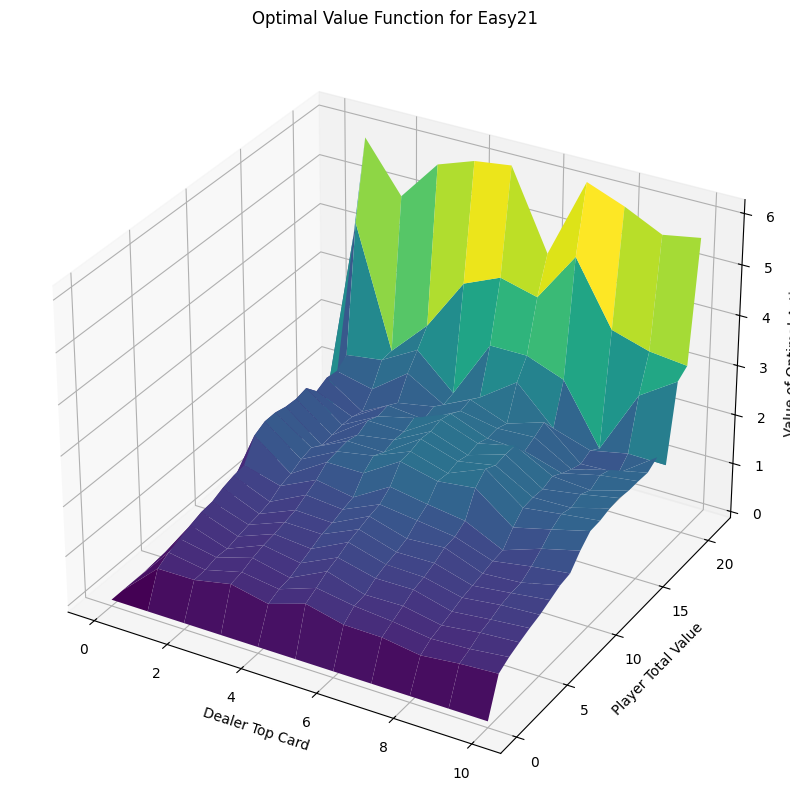

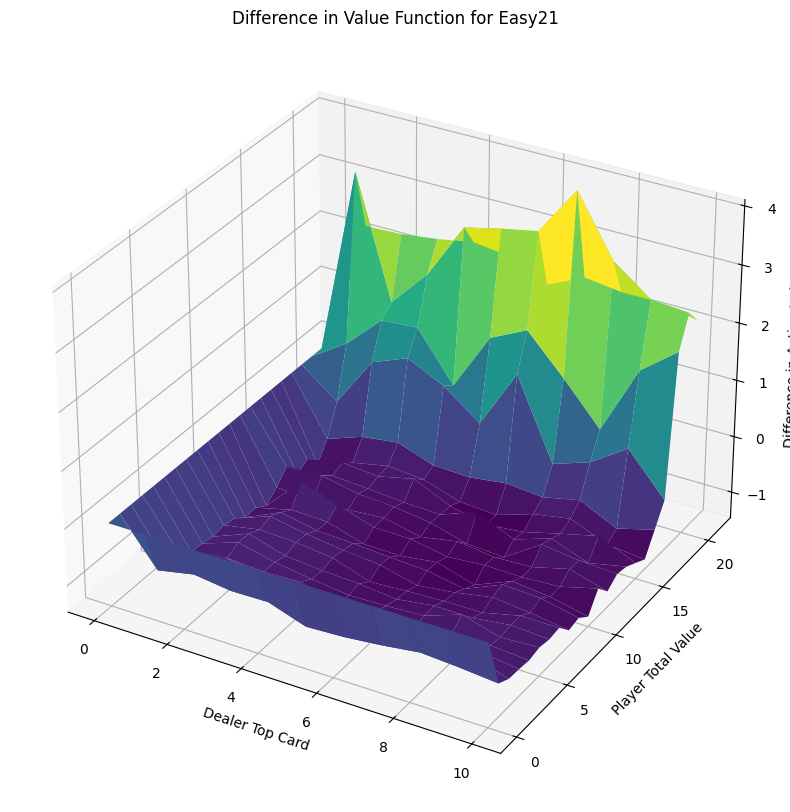

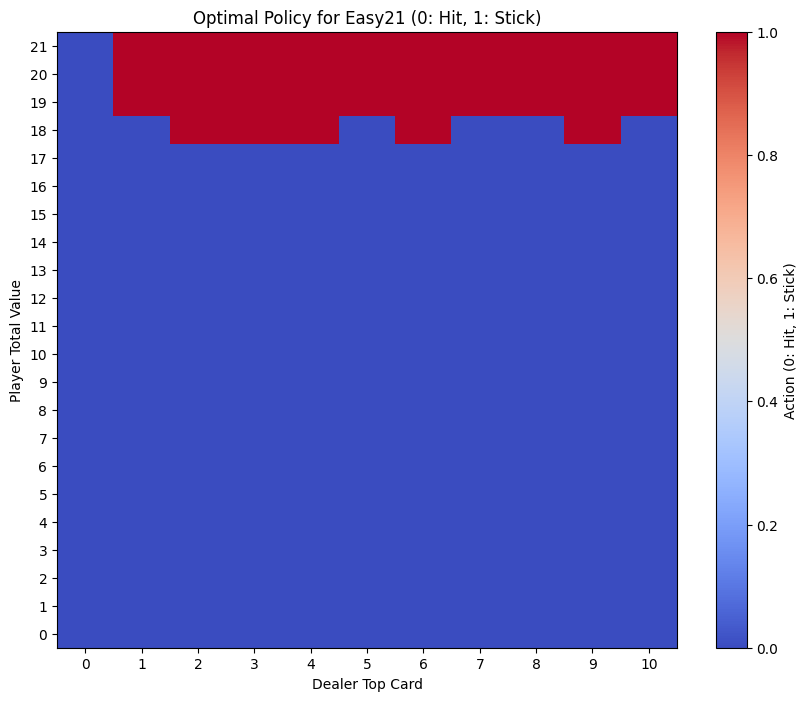

In [33]:
plot_for_lambda(1)

In [ ]:
def plot_value_convergence(V, lambda_values, states_to_plot, actions_to_plot):
    fig, axes = plt.subplots(len(states_to_plot), len(actions_to_plot),
                            figsize=(15, 4 * len(states_to_plot)))

    if len(states_to_plot) == 1 and len(actions_to_plot) == 1:
        axes = [[axes]]
    elif len(states_to_plot) == 1:
        axes = [axes]
    elif len(actions_to_plot) == 1:
        axes = [[ax] for ax in axes]

    episode_indices = np.arange(0, number_of_episodes, max(1, number_of_episodes // 1000))

    for state_idx, (dealer_card, player_sum) in enumerate(states_to_plot):
        for action_idx, action in enumerate(actions_to_plot):
            ax = axes[state_idx][action_idx]

            for lambda_idx, lambda_val in enumerate(lambda_values):
                values = V[dealer_card, player_sum, action, lambda_idx, episode_indices]
                ax.plot(episode_indices, values, label=f'λ={lambda_val}', alpha=0.7)

            ax.set_xlabel('Episode')
            ax.set_ylabel('Value')
            ax.set_title(f'State ({dealer_card}, {player_sum}), Action {action}')
            ax.legend()
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_value_heatmaps(V, lambda_values, episode_idx=-1, action=0):
    n_lambdas = len(lambda_values)
    cols = 4
    rows = (n_lambdas + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    axes = axes.flatten() if n_lambdas > 1 else [axes]

    for lambda_idx, lambda_val in enumerate(lambda_values):
        ax = axes[lambda_idx]

        values = V[1:11, 1:22, action, lambda_idx, episode_idx]

        im = ax.imshow(values.T, cmap='RdYlBu', aspect='auto', origin='lower')
        ax.set_xlabel('Dealer Card')
        ax.set_ylabel('Player Sum')
        ax.set_title(f'λ={lambda_val}, Action={action}')
        ax.set_xticks(range(10))
        ax.set_xticklabels(range(1, 11))
        ax.set_yticks(range(0, 21, 2))
        ax.set_yticklabels(range(1, 22, 2))

        plt.colorbar(im, ax=ax)

    # Hide unused subplots
    for i in range(n_lambdas, len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

def plot_lambda_comparison(V, lambda_values, dealer_card=5, player_sum=15):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    episode_indices = np.arange(0, number_of_episodes, max(1, number_of_episodes // 1000))

    for lambda_idx, lambda_val in enumerate(lambda_values):
        values = V[dealer_card, player_sum, 0, lambda_idx, episode_indices]
        ax1.plot(episode_indices, values, label=f'λ={lambda_val}', alpha=0.7)

    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Value')
    ax1.set_title(f'Action 0 (Hit) - State ({dealer_card}, {player_sum})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    for lambda_idx, lambda_val in enumerate(lambda_values):
        values = V[dealer_card, player_sum, 1, lambda_idx, episode_indices]
        ax2.plot(episode_indices, values, label=f'λ={lambda_val}', alpha=0.7)

    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Value')
    ax2.set_title(f'Action 1 (Stick) - State ({dealer_card}, {player_sum})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


Training completed!
Plotting value function convergence...


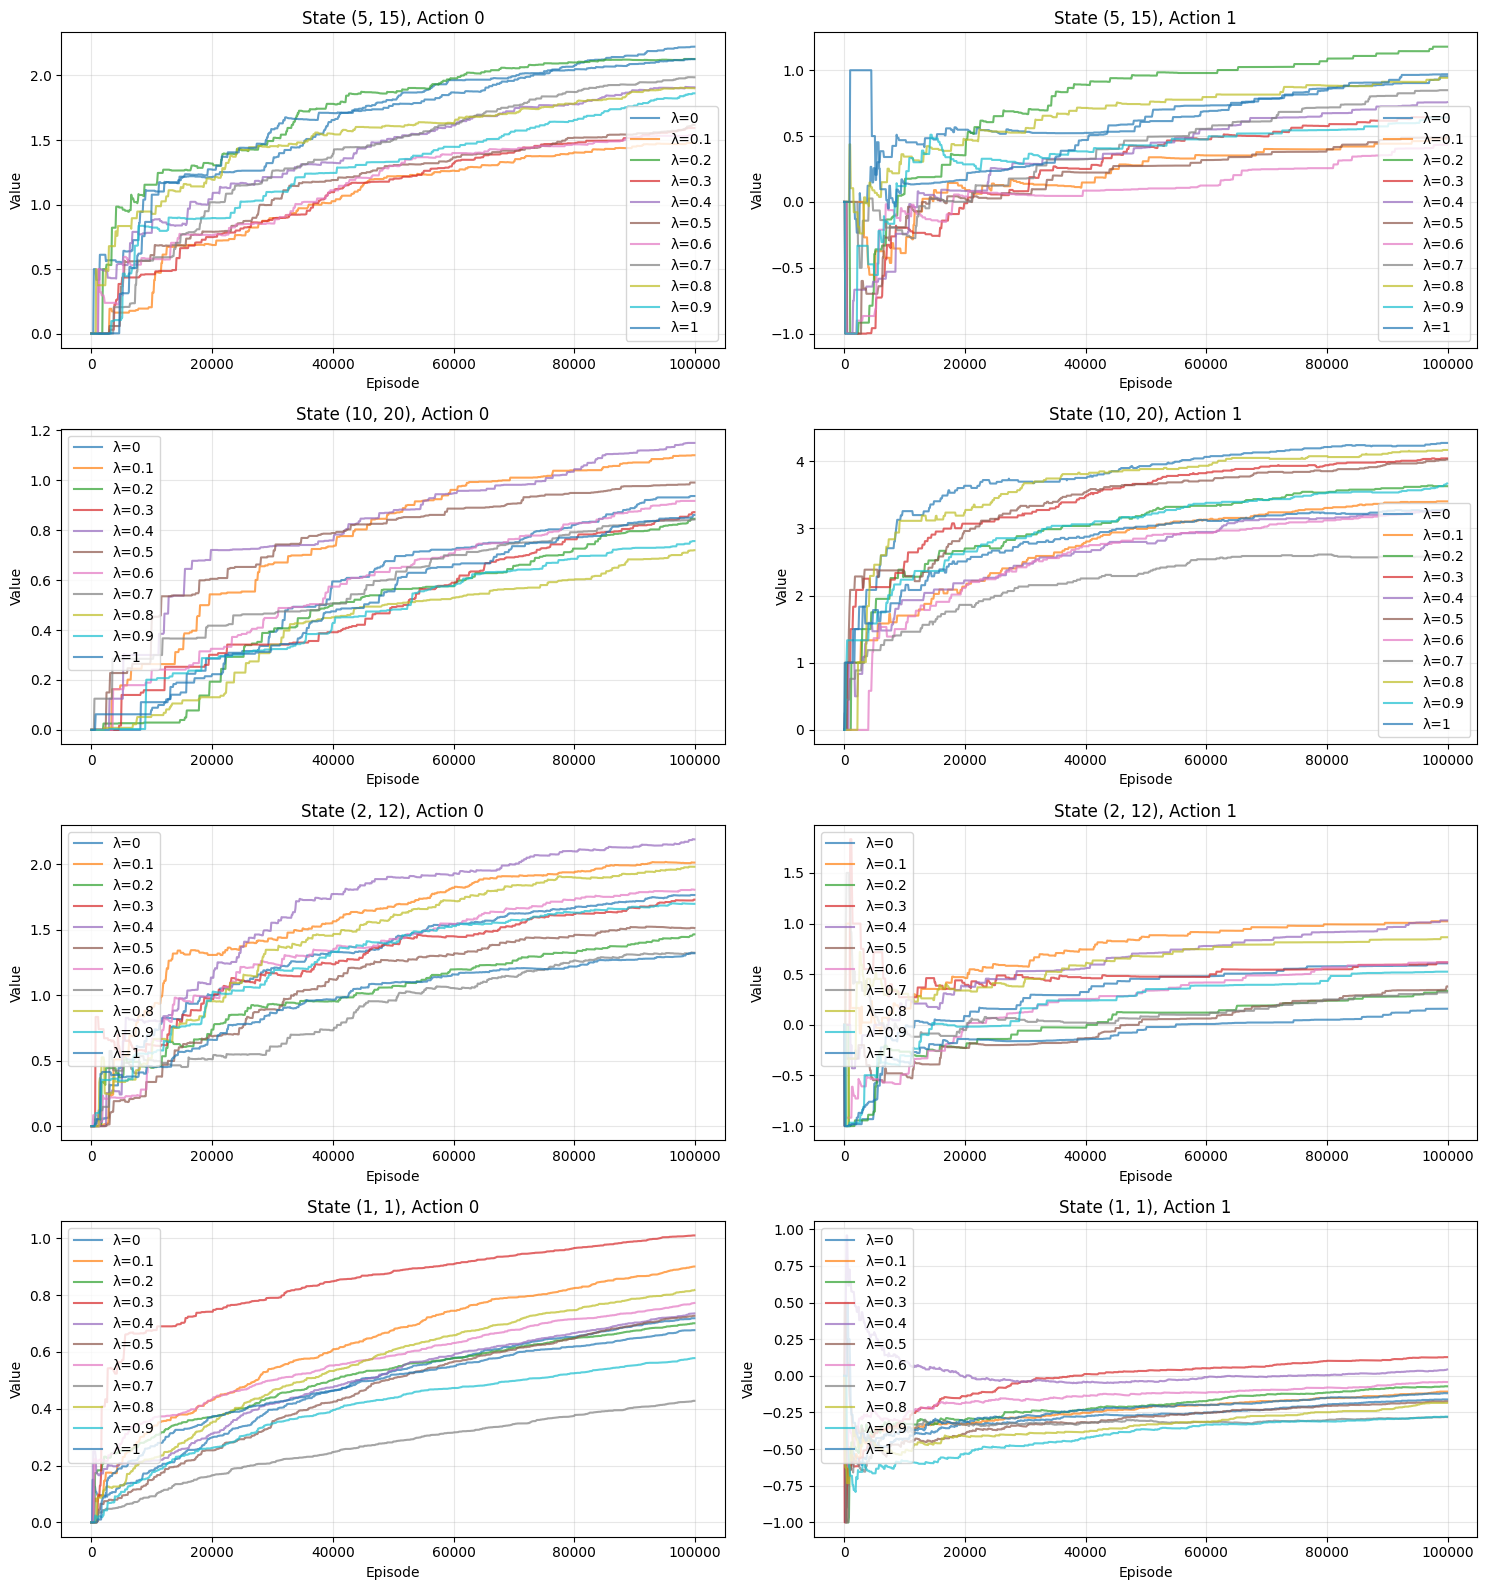

Plotting value function heatmaps...


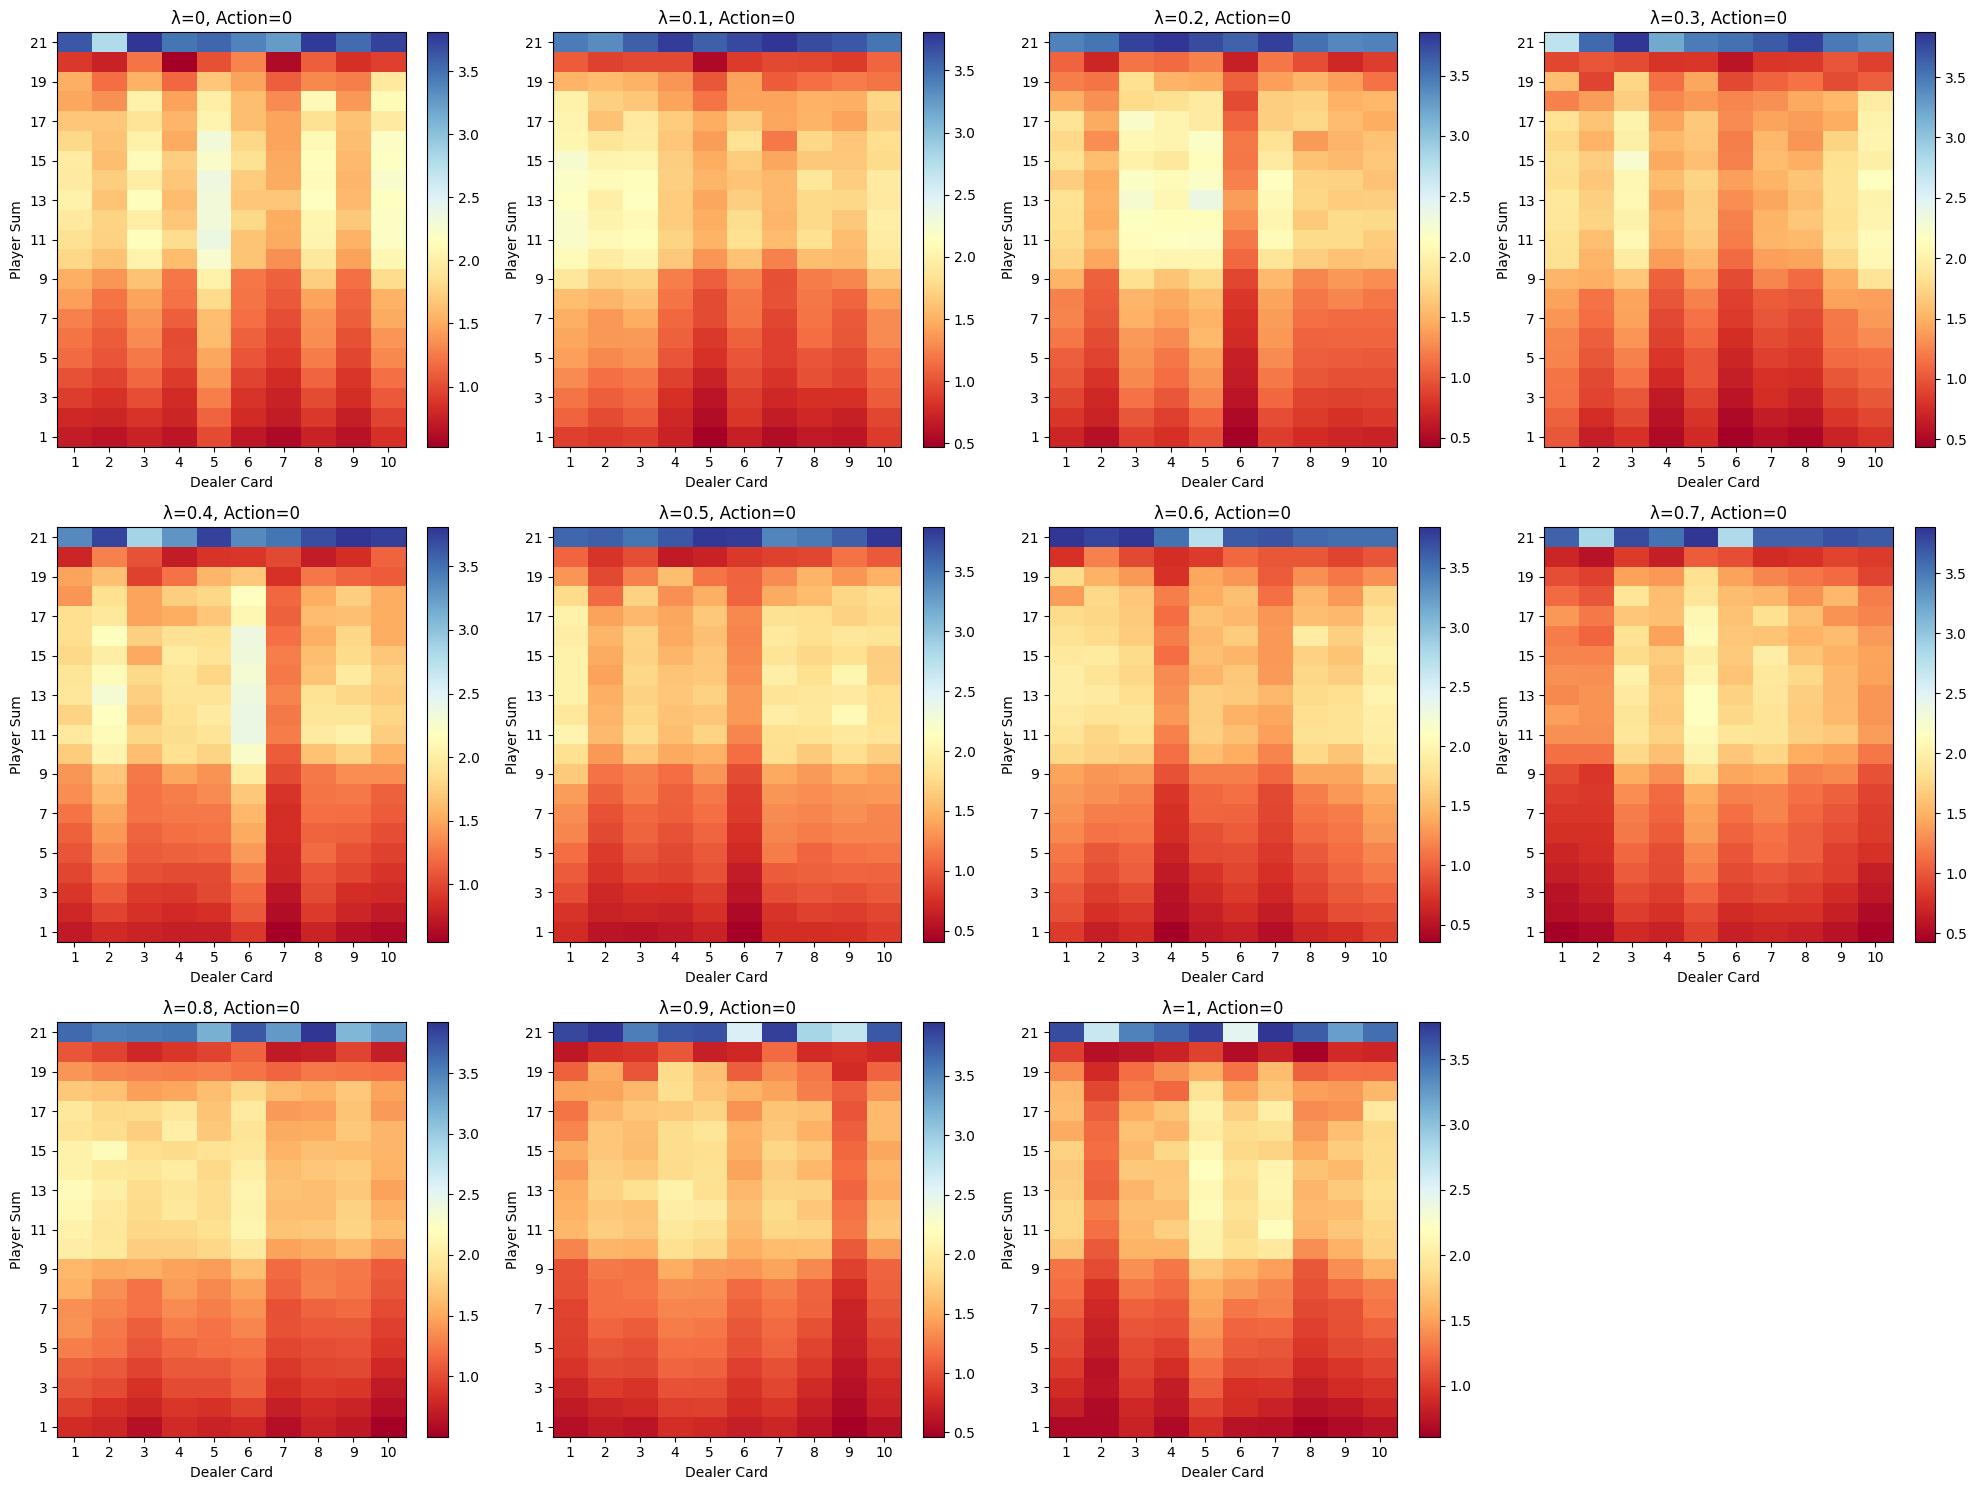

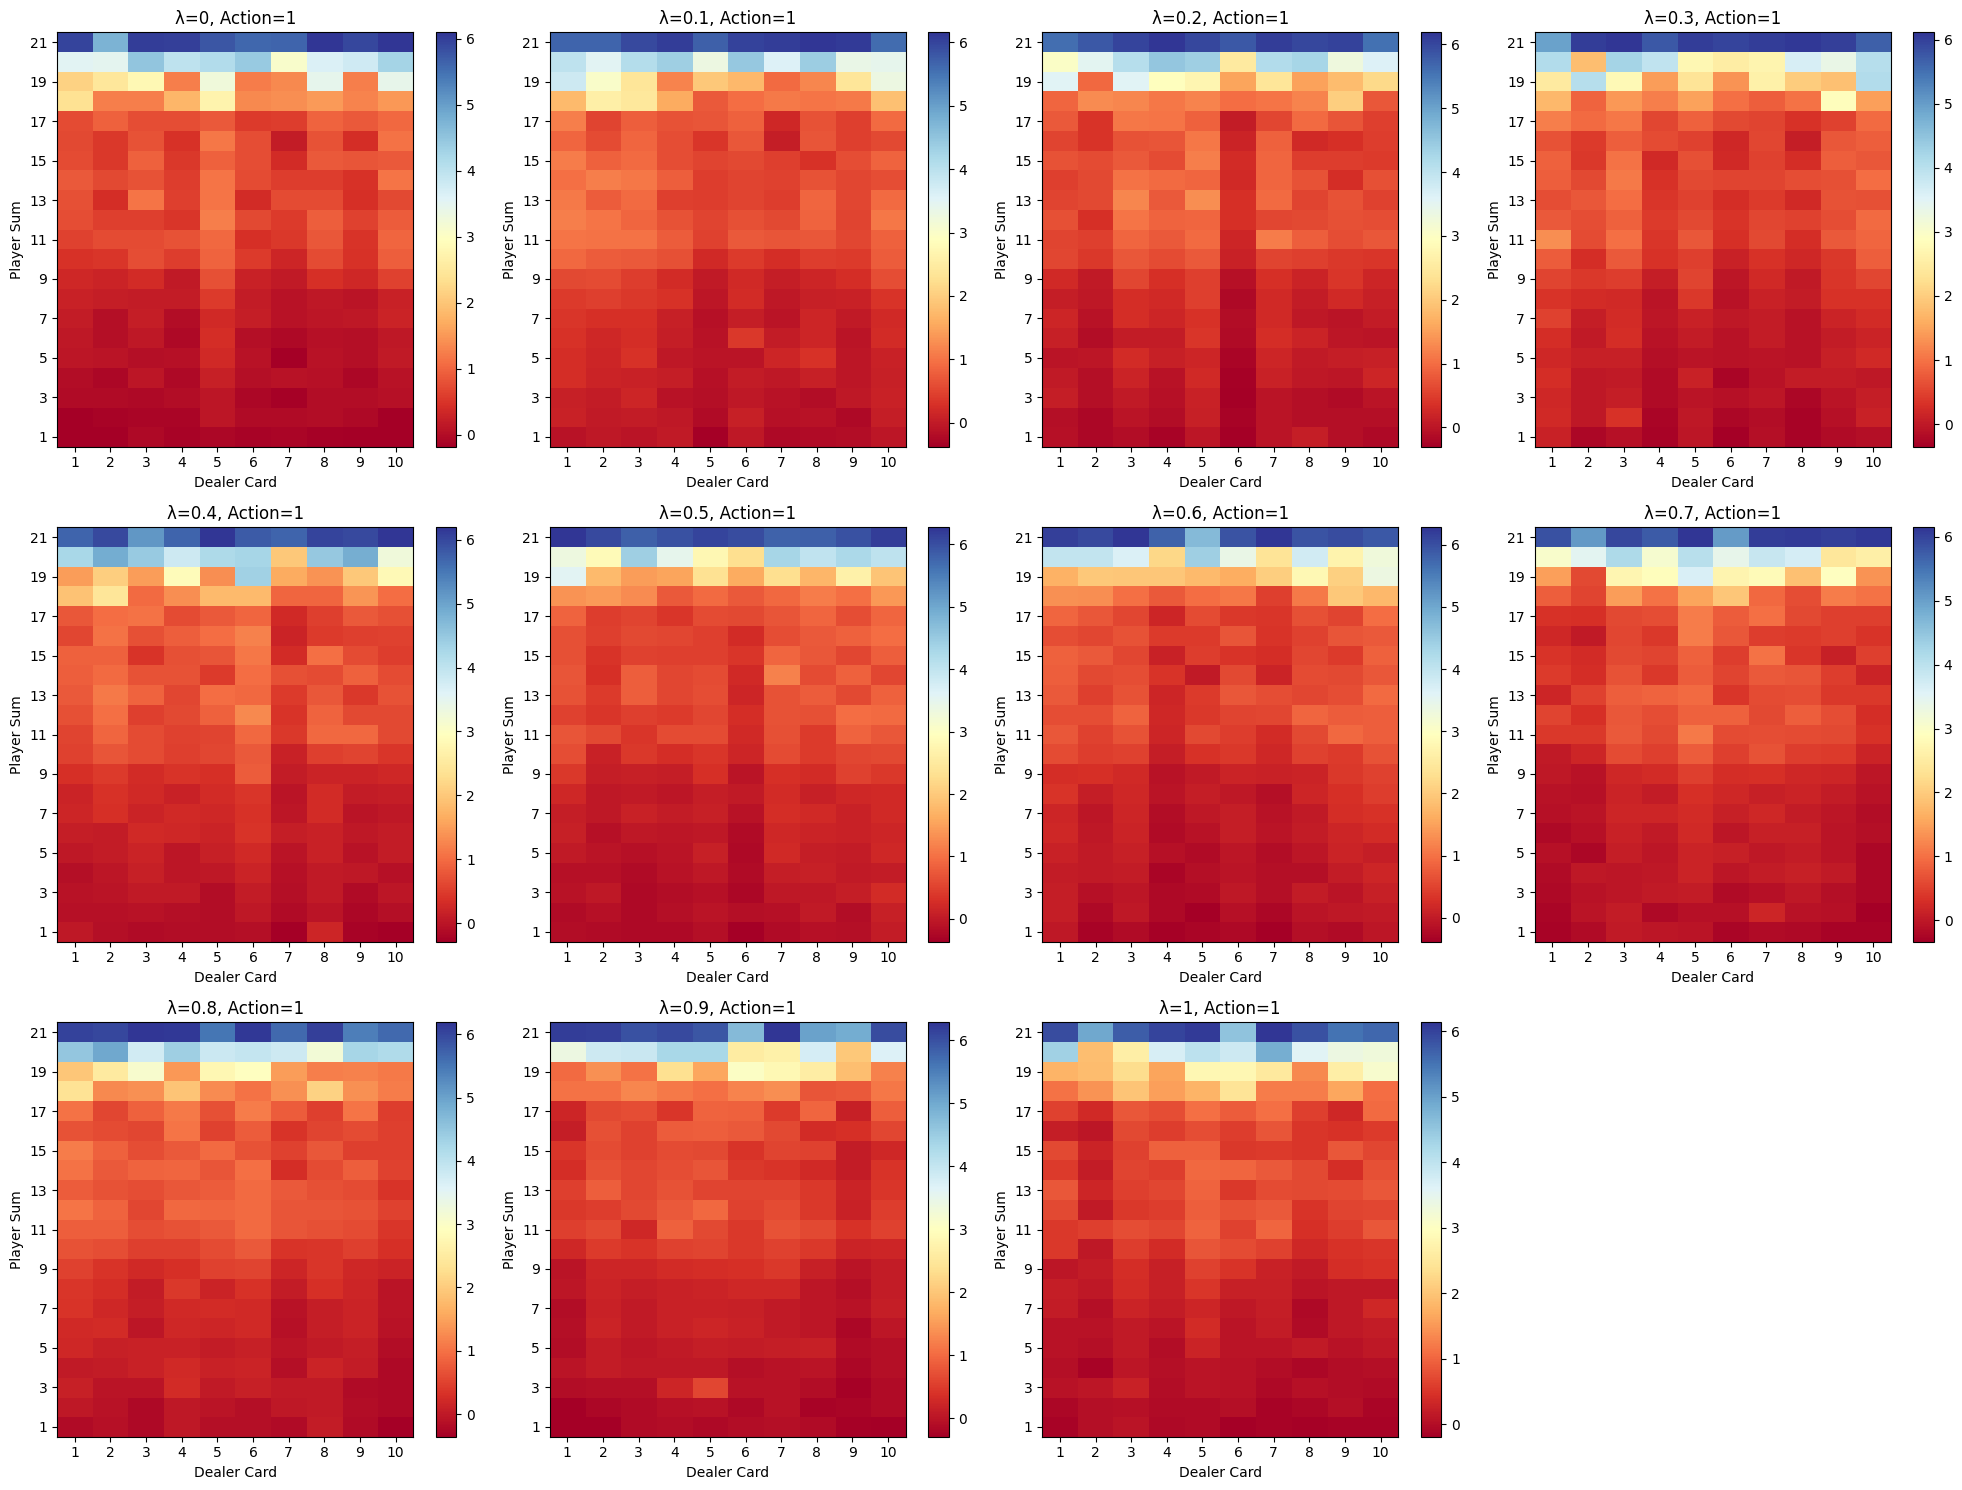

Plotting lambda comparison...


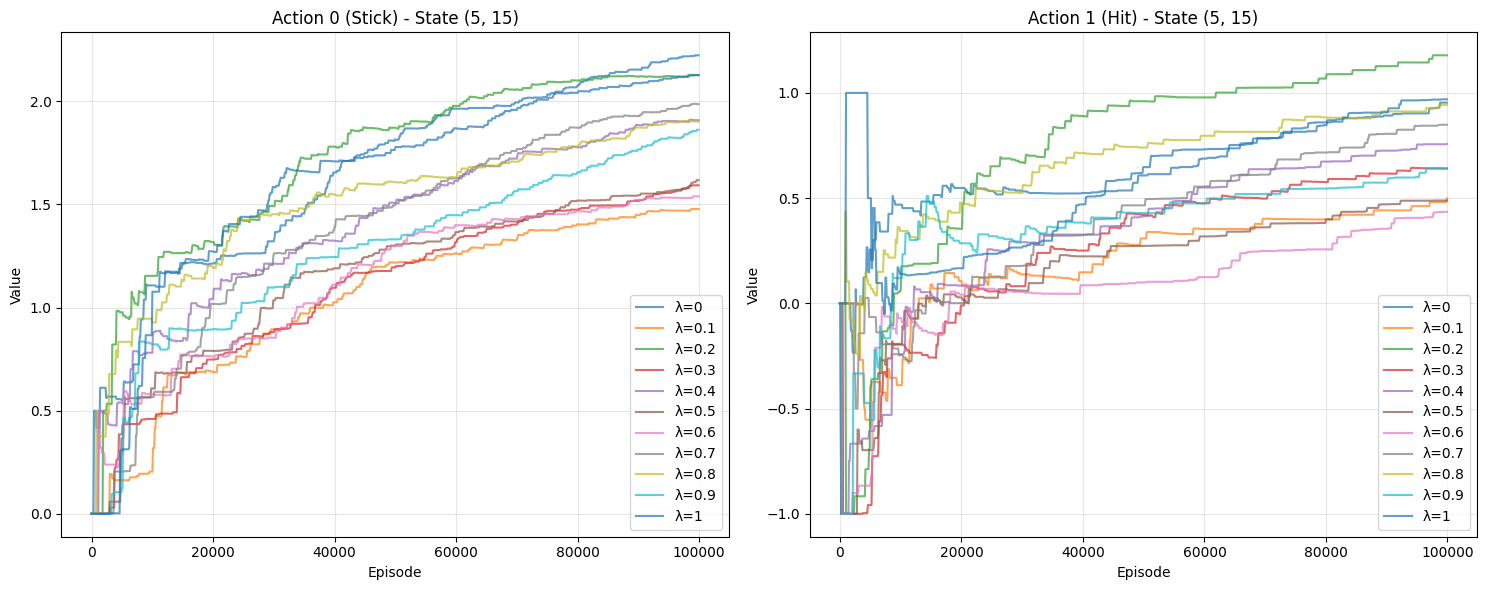

In [ ]:
print("Training completed!")
states_to_analyze = [(5, 15), (10, 20), (2, 12), (1, 1)]
actions_to_analyze = [0, 1]

print("Plotting value function convergence...")
plot_value_convergence(V, lambda_values, states_to_analyze, actions_to_analyze)

print("Plotting value function heatmaps...")
plot_value_heatmaps(V, lambda_values, episode_idx=-1, action=0)
plot_value_heatmaps(V, lambda_values, episode_idx=-1, action=1)

print("Plotting lambda comparison...")
plot_lambda_comparison(V, lambda_values, dealer_card=5, player_sum=15)

In [ ]:
def plot_regret_analysis(instantaneous_regret, cumulative_regret, lambda_values):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    for lambda_idx, lambda_val in enumerate(lambda_values):
        window_size = 1000
        smoothed_regret = np.convolve(instantaneous_regret[lambda_idx],
                                    np.ones(window_size)/window_size, mode='valid')
        plt.plot(smoothed_regret, label=f'λ={lambda_val}')
    plt.xlabel('Episode')
    plt.ylabel('Instantaneous Regret (Smoothed)')
    plt.title('Instantaneous Regret vs Episodes')
    plt.legend()

    plt.subplot(1, 2, 2)
    for lambda_idx, lambda_val in enumerate(lambda_values):
        plt.plot(cumulative_regret[lambda_idx], label=f'λ={lambda_val}')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Regret')
    plt.title('Cumulative Regret vs Episodes')
    plt.legend()

    plt.tight_layout()
    plt.show()

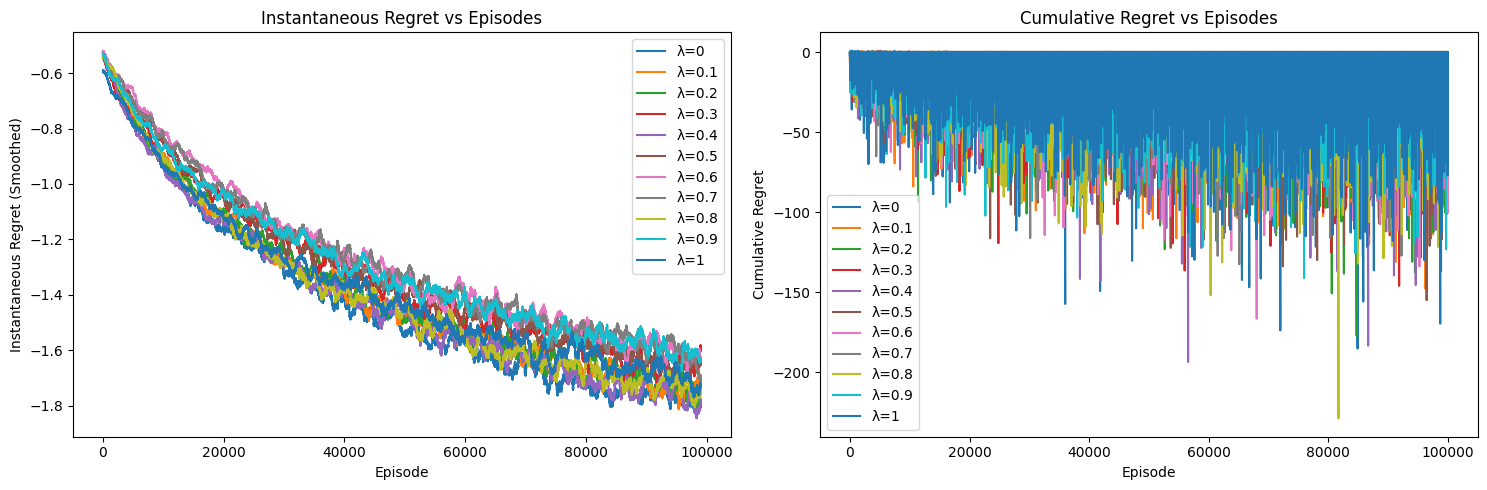

In [37]:
plot_regret_analysis(instantaneous_regret, cumulative_regret, lambda_values)